In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
train_data = pd.read_csv('Dataset/DailyDelhiClimateTrain.csv')
test_data = pd.read_csv('Dataset/DailyDelhiClimateTest.csv')

train_data = train_data.ffill()
test_data = test_data.ffill()

scaler = MinMaxScaler()
train_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = scaler.fit_transform(
    train_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])
test_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = scaler.transform(
    test_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])

def create_sequences(data, seq_length=30):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][0]  # Predicting mean temperature
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X_train, y_train = create_sequences(train_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].values, seq_length)
X_test, y_test = create_sequences(test_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].values, seq_length)

In [18]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
mse_loss = nn.MSELoss()

class NovelLossFunction(nn.Module):
    def __init__(self):
        super(NovelLossFunction, self).__init__()

    def forward(self, y_pred, y_true):
        n = y_true.shape[0]
        weights = torch.arange(1, n+1, dtype=torch.float32) / n
        return torch.mean(weights * torch.abs(y_true - y_pred))


class mae_loss(nn.Module):
    def __init__(self):
        super(mae_loss, self).__init__()

    def forward(self, y_pred, y_true):
        n = y_true.shape[0]
        return torch.mean(torch.abs(y_true - y_pred))

class HuberLossFunction(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLossFunction, self).__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        error = y_true - y_pred
        is_small_error = torch.abs(error) <= self.delta
        small_error_loss = 0.5 * torch.pow(error, 2)
        large_error_loss = self.delta * (torch.abs(error) - 0.5 * self.delta)
        return torch.mean(torch.where(is_small_error, small_error_loss, large_error_loss))


In [23]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

In [26]:


def train_and_evaluate(model, loss_fn, optimizer, train_loader, test_loader, epochs=100):
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        
        model.eval()
        test_loss = 0
        y_true, y_pred_list = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch).squeeze()
                loss = loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                y_true.extend(y_batch.tolist())
                y_pred_list.extend(y_pred.tolist())

        test_losses.append(test_loss / len(test_loader))
        mae = mean_absolute_error(y_true, y_pred_list)
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, MAE: {mae:.4f}")
    return y_true, y_pred_list, train_losses, test_losses


results = {}
loss_curves = {}

In [27]:
model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("Training with MSE Loss Function")
y_true_mse, y_pred_mse, train_losses_mse, test_losses_mse = train_and_evaluate(model, mse_loss, optimizer, train_loader, test_loader)
results['MSE Loss Function'] = (y_true_mse, y_pred_mse)
loss_curves['MSE Loss Function'] = (train_losses_mse, test_losses_mse)

Training with MSE Loss Function
Epoch 1, Train Loss: 0.1218, Test Loss: 0.0239, MAE: 0.1354
Epoch 2, Train Loss: 0.0192, Test Loss: 0.0059, MAE: 0.0692
Epoch 3, Train Loss: 0.0064, Test Loss: 0.0054, MAE: 0.0649
Epoch 4, Train Loss: 0.0052, Test Loss: 0.0055, MAE: 0.0627
Epoch 5, Train Loss: 0.0049, Test Loss: 0.0057, MAE: 0.0630
Epoch 6, Train Loss: 0.0047, Test Loss: 0.0057, MAE: 0.0631
Epoch 7, Train Loss: 0.0048, Test Loss: 0.0054, MAE: 0.0615
Epoch 8, Train Loss: 0.0046, Test Loss: 0.0054, MAE: 0.0625
Epoch 9, Train Loss: 0.0044, Test Loss: 0.0057, MAE: 0.0629
Epoch 10, Train Loss: 0.0044, Test Loss: 0.0053, MAE: 0.0608
Epoch 11, Train Loss: 0.0042, Test Loss: 0.0052, MAE: 0.0621
Epoch 12, Train Loss: 0.0041, Test Loss: 0.0052, MAE: 0.0616
Epoch 13, Train Loss: 0.0042, Test Loss: 0.0052, MAE: 0.0615
Epoch 14, Train Loss: 0.0040, Test Loss: 0.0052, MAE: 0.0607
Epoch 15, Train Loss: 0.0040, Test Loss: 0.0049, MAE: 0.0589
Epoch 16, Train Loss: 0.0039, Test Loss: 0.0049, MAE: 0.0594
E

In [28]:
model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("\nTraining with Novel Loss Function")
y_true_novel, y_pred_novel, train_losses_novel, test_losses_novel = train_and_evaluate(model, NovelLossFunction(), optimizer, train_loader, test_loader)
results['Novel Loss Function'] = (y_true_novel, y_pred_novel)
loss_curves['Novel Loss Function'] = (train_losses_novel, test_losses_novel)


Training with Novel Loss Function
Epoch 1, Train Loss: 0.1681, Test Loss: 0.0675, MAE: 0.1434
Epoch 2, Train Loss: 0.0541, Test Loss: 0.0308, MAE: 0.0690
Epoch 3, Train Loss: 0.0306, Test Loss: 0.0333, MAE: 0.0643
Epoch 4, Train Loss: 0.0286, Test Loss: 0.0296, MAE: 0.0644
Epoch 5, Train Loss: 0.0279, Test Loss: 0.0292, MAE: 0.0654
Epoch 6, Train Loss: 0.0283, Test Loss: 0.0287, MAE: 0.0617
Epoch 7, Train Loss: 0.0268, Test Loss: 0.0358, MAE: 0.0644
Epoch 8, Train Loss: 0.0255, Test Loss: 0.0335, MAE: 0.0627
Epoch 9, Train Loss: 0.0261, Test Loss: 0.0425, MAE: 0.0710
Epoch 10, Train Loss: 0.0278, Test Loss: 0.0388, MAE: 0.0668
Epoch 11, Train Loss: 0.0260, Test Loss: 0.0294, MAE: 0.0588
Epoch 12, Train Loss: 0.0259, Test Loss: 0.0312, MAE: 0.0591
Epoch 13, Train Loss: 0.0251, Test Loss: 0.0310, MAE: 0.0588
Epoch 14, Train Loss: 0.0245, Test Loss: 0.0328, MAE: 0.0600
Epoch 15, Train Loss: 0.0267, Test Loss: 0.0336, MAE: 0.0610
Epoch 16, Train Loss: 0.0272, Test Loss: 0.0266, MAE: 0.054

In [29]:
model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("Training with MAE Loss Function")
y_true_mae, y_pred_mae, train_losses_mae, test_losses_mae = train_and_evaluate(model, mae_loss(), optimizer, train_loader, test_loader)
results['MAE Loss Function'] = (y_true_mae, y_pred_mae)
loss_curves['MAE Loss Function'] = (train_losses_mae, test_losses_mae)

Training with MAE Loss Function
Epoch 1, Train Loss: 0.2699, Test Loss: 0.1501, MAE: 0.1523
Epoch 2, Train Loss: 0.1084, Test Loss: 0.0717, MAE: 0.0731
Epoch 3, Train Loss: 0.0569, Test Loss: 0.0640, MAE: 0.0653
Epoch 4, Train Loss: 0.0538, Test Loss: 0.0655, MAE: 0.0664
Epoch 5, Train Loss: 0.0536, Test Loss: 0.0621, MAE: 0.0628
Epoch 6, Train Loss: 0.0505, Test Loss: 0.0613, MAE: 0.0619
Epoch 7, Train Loss: 0.0516, Test Loss: 0.0622, MAE: 0.0627
Epoch 8, Train Loss: 0.0492, Test Loss: 0.0606, MAE: 0.0610
Epoch 9, Train Loss: 0.0492, Test Loss: 0.0611, MAE: 0.0615
Epoch 10, Train Loss: 0.0477, Test Loss: 0.0577, MAE: 0.0582
Epoch 11, Train Loss: 0.0480, Test Loss: 0.0571, MAE: 0.0577
Epoch 12, Train Loss: 0.0470, Test Loss: 0.0554, MAE: 0.0560
Epoch 13, Train Loss: 0.0465, Test Loss: 0.0563, MAE: 0.0569
Epoch 14, Train Loss: 0.0465, Test Loss: 0.0533, MAE: 0.0540
Epoch 15, Train Loss: 0.0452, Test Loss: 0.0549, MAE: 0.0553
Epoch 16, Train Loss: 0.0458, Test Loss: 0.0521, MAE: 0.0530
E

In [30]:

model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
huber_loss = HuberLossFunction(delta=1.0)
print("\nTraining with Huber Loss Function")
y_true_huber, y_pred_huber, train_losses_huber, test_losses_huber = train_and_evaluate(
    model, huber_loss, optimizer, train_loader, test_loader
)
results['Huber Loss Function'] = (y_true_huber, y_pred_huber)
loss_curves['Huber Loss Function'] = (train_losses_huber, test_losses_huber)


Training with Huber Loss Function
Epoch 1, Train Loss: 0.0526, Test Loss: 0.0125, MAE: 0.1383
Epoch 2, Train Loss: 0.0094, Test Loss: 0.0034, MAE: 0.0714
Epoch 3, Train Loss: 0.0032, Test Loss: 0.0029, MAE: 0.0654
Epoch 4, Train Loss: 0.0025, Test Loss: 0.0028, MAE: 0.0629
Epoch 5, Train Loss: 0.0023, Test Loss: 0.0027, MAE: 0.0628
Epoch 6, Train Loss: 0.0022, Test Loss: 0.0027, MAE: 0.0622
Epoch 7, Train Loss: 0.0022, Test Loss: 0.0029, MAE: 0.0635
Epoch 8, Train Loss: 0.0023, Test Loss: 0.0027, MAE: 0.0620
Epoch 9, Train Loss: 0.0022, Test Loss: 0.0026, MAE: 0.0608
Epoch 10, Train Loss: 0.0021, Test Loss: 0.0026, MAE: 0.0604
Epoch 11, Train Loss: 0.0021, Test Loss: 0.0029, MAE: 0.0635
Epoch 12, Train Loss: 0.0020, Test Loss: 0.0025, MAE: 0.0612
Epoch 13, Train Loss: 0.0020, Test Loss: 0.0028, MAE: 0.0615
Epoch 14, Train Loss: 0.0020, Test Loss: 0.0025, MAE: 0.0597
Epoch 15, Train Loss: 0.0020, Test Loss: 0.0024, MAE: 0.0583
Epoch 16, Train Loss: 0.0020, Test Loss: 0.0027, MAE: 0.060

In [31]:
# Print final accuracy in percentage
for loss_name, (y_true, y_pred) in results.items():
    mae = mean_absolute_error(y_true, y_pred)
    accuracy = (1 - mae) * 100
    print(f"Accuracy of the model trained with {loss_name}: {accuracy:.2f}%")

from sklearn.metrics import r2_score

for loss_name, (y_true, y_pred) in results.items():
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Performance of the model trained with {loss_name}:")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - R^2 Score: {r2:.4f}")

Accuracy of the model trained with MSE Loss Function: 95.82%
Accuracy of the model trained with Novel Loss Function: 96.12%
Accuracy of the model trained with MAE Loss Function: 96.08%
Accuracy of the model trained with Huber Loss Function: 95.84%
Performance of the model trained with MSE Loss Function:
  - Mean Absolute Error (MAE): 0.0418
  - R^2 Score: 0.9176
Performance of the model trained with Novel Loss Function:
  - Mean Absolute Error (MAE): 0.0388
  - R^2 Score: 0.9278
Performance of the model trained with MAE Loss Function:
  - Mean Absolute Error (MAE): 0.0392
  - R^2 Score: 0.9269
Performance of the model trained with Huber Loss Function:
  - Mean Absolute Error (MAE): 0.0416
  - R^2 Score: 0.9180


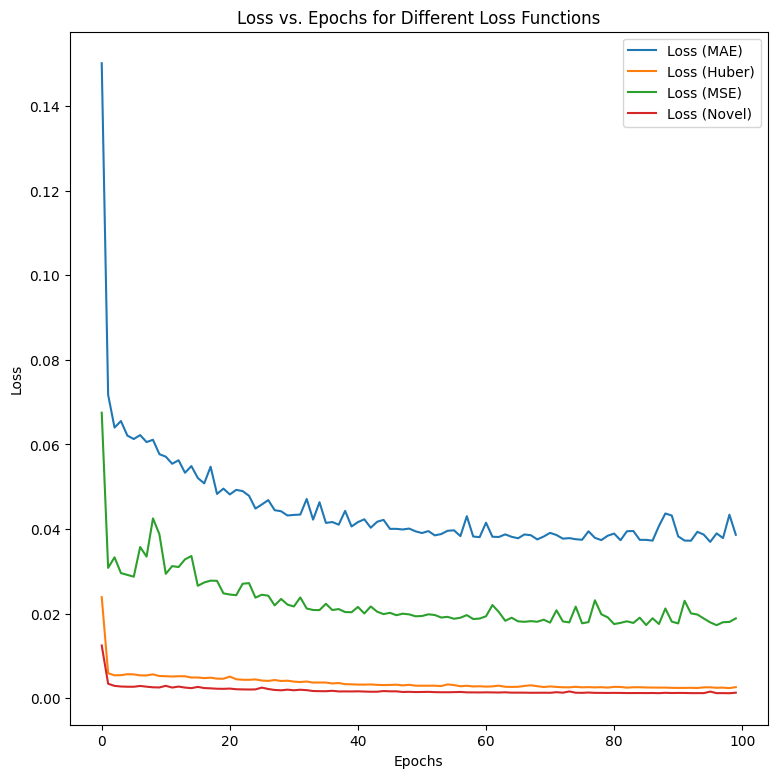

In [38]:
plt.figure(figsize=(9, 9))
plt.plot(test_losses_mae, label='Loss (MAE)')
plt.plot(test_losses_mse, label='Loss (Huber)')
plt.plot(test_losses_novel, label='Loss (MSE)')
plt.plot(test_losses_huber, label='Loss (Novel)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs for Different Loss Functions')
plt.legend()
plt.show()


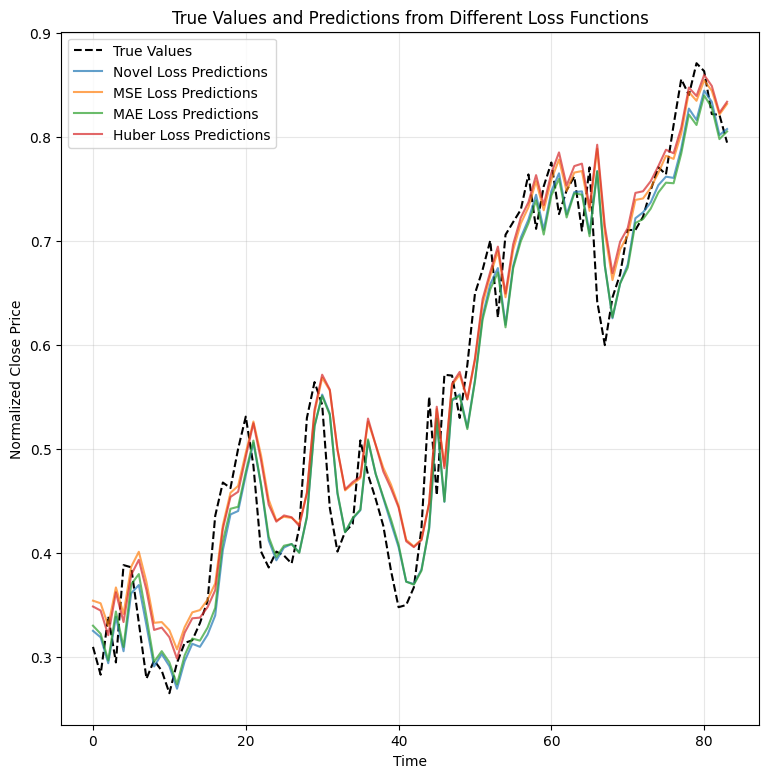

In [37]:
# Plot predictions from all models along with the true values
plt.figure(figsize=(9, 9))

plt.plot(y_true_mse, label='True Values', color='black', linestyle='--', linewidth=1.5)
plt.plot(y_pred_novel, label='Novel Loss Predictions', alpha=0.7)
plt.plot(y_pred_mse, label='MSE Loss Predictions', alpha=0.7)
plt.plot(y_pred_mae, label='MAE Loss Predictions', alpha=0.7)
plt.plot(y_pred_huber, label='Huber Loss Predictions', alpha=0.7)

plt.title('True Values and Predictions from Different Loss Functions')
plt.xlabel('Time')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.grid(alpha=0.3)
plt.show()